<a href="https://colab.research.google.com/github/seeedata/SK-AI-Data-Academy/blob/main/SK%20hynix%20DRAM%20%EB%82%B4%EB%B6%80%20%ED%9A%8C%EB%A1%9C%EC%9D%98%20%ED%8C%8C%ED%98%95%20%EC%98%88%EC%B8%A1/%5B%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B83%5D%20RNN%20%EA%B8%B0%EB%B0%98%20%EB%AA%A8%EB%8D%B8%EC%9D%84%20%ED%99%9C%EC%9A%A9%ED%95%9C%20%ED%8C%8C%ED%98%95%20%EC%98%88%EC%B8%A1%ED%95%98%EA%B8%B0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# [프로젝트3] RNN 기반 모델을 활용한 파형 예측하기


---


## 프로젝트 목표
---
- RNN 기반 딥러닝 모델에 적용할 수 있도록 데이터셋을 구성해봅니다.
- pytorch를 활용하여 여러가지 RNN 모델을 훈련하고 테스트해봅니다.

## 프로젝트 목차
---

1. **데이터 읽기:** 전압 데이터를 불러오고 numpy array 형태로 변환

2. **데이터 전처리:** 불러온 데이터를 시계열 모델에 적용할 수 있도록 전처리

3. **데이터 시각화:** 시각화를 통한 데이터의 이해

4. **머신러닝 모델 수행:** 시계열 모델을 사용하여 학습 수행, 평가 및 예측 수행

4. **더 해보기:** 시계열 머신러닝 모델의 성능을 향상시키기 위한 방법들


## 프로젝트 개요
---

이번 장에서는 시계열 데이터를 다루기에 적합한 RNN 기반의 딥러닝 모델을 사용해보겠습니다.

RNN 기반 딥러닝 모델은 일반 회귀모델과 달리 시계열 데이터를 입력 받습니다.

따라서, 앞 장에서 사용한 데이터를 적절하게 전처리하여 시계열 데이터로 변환해야 합니다.

이러한 시계열 데이터를 가장 잘 다룰 수 있는 모델 중 하나는 RNN 기반 모델입니다.

pytorch 라이브러리를 활용하여 대표적인 RNN 기반 모델인 LSTM과 GRU 모델을 학습하고 예측 및 평가해보겠습니다.


## 1. 데이터 읽기
---
프로젝트 1에서와 같이 데이터를 불러오고 정제한 후 전처리합니다.


In [ ]:
import pandas as pd

# 데이터 불러오기
df_train = pd.read_csv('./dataset/SKHY_train.txt', delimiter=',', header=0)
df_test = pd.read_csv('./dataset/SKHY_test_answer.txt', delimiter=',', header=0)

# 데이터 정제
# 학습용 데이터와 검증용 데이터의 비율을 9:1로 설정합니다.
train_valid_ratio = 0.9
train_len = int(df_train.shape[0] * train_valid_ratio)
valid_len = df_train.shape[0] - train_len
test_len = df_test.shape[0]
train_data = {
    'time': df_train.iloc[:, 0].values[:train_len],
    'X': df_train.iloc[:, 1].values[:train_len],
    'y': df_train.iloc[:, 2:].values[:train_len]
}
valid_data = {
    'time': df_train.iloc[:, 0].values[train_len:],
    'X': df_train.iloc[:, 1].values[train_len:],
    'y': df_train.iloc[:, 2:].values[train_len:]
}
test_data = {
    'time': df_test.iloc[:, 0].values,
    'X': df_test.iloc[:, 1].values,
    'y': df_test.iloc[:, 2:].values
}

# 데이터 정규화
X_mean = train_data['X'].mean()
X_std = train_data['X'].std()

X_train = (train_data['X'] - X_mean) / X_std
X_train = X_train.reshape(-1, 1)
X_valid = (valid_data['X'] - X_mean) / X_std
X_valid = X_valid.reshape(-1, 1)
X_test = (test_data['X'] - X_mean) / X_std
X_test = X_test.reshape(-1, 1)

y_mean = train_data['y'].mean(axis=0)
y_std = train_data['y'].std(axis=0)
y_train = (train_data['y'] - y_mean) / y_std
y_valid = (valid_data['y'] - y_mean) / y_std
y_test = (test_data['y'] - y_mean) / y_std

print('X_train shape: {}, y_train shape: {}'.format(X_train.shape, y_train.shape))
print('X_valid shape: {}, y_valid shape: {}'.format(X_valid.shape, y_valid.shape))
print('X_test shape: {}, y_test shape: {}'.format(X_test.shape, y_test.shape))

X_train shape: (407054, 1), y_train shape: (407054, 5)
X_valid shape: (45229, 1), y_valid shape: (45229, 5)
X_test shape: (193836, 1), y_test shape: (193836, 5)


`X_train`과 `y_train`은 학습데이터, `X_valid`와 `y_valid`는 검증데이터, 그리고 `X_test`와 `y_test`는 테스트 데이터입니다.

## 2. 데이터 전처리
---
읽어온 데이터를 RNN 기반 딥러닝 모델에 적용할 수 있도록 전처리합니다.


### 2.1 라이브러리 불러오기
---

In [ ]:
import numpy as np

### 2.2 시계열 데이터 생성
---
RNN 기반의 모델에 적용하기 위해 입력 데이터 (`X`)는 <b><i>[#data, #sequence, #dimension]</i></b>의 shape을 가져야 합니다. <b><i>#data</i></b>는 데이터의 개수이고, <b><i>#sequence</i></b>는 window size이며, <b><i>#dimension</i></b>은 입력 데이터의 차원을 의미합니다.

In [ ]:
# 읽어온 데이터를 시계열 데이터로 변환해줍니다.
def process_data(X, y, num_sequences, stride = 1, interval = 1):
    X_ = []
    for i in range(0, num_sequences * interval, interval):
        X_.append(X[i:len(X) - num_sequences * interval + 1 + i])
    X_ = np.asarray(X_)[:, ::stride].transpose().reshape(-1, num_sequences, 1)
    return X_, y[num_sequences * interval-1::stride]

읽어온 데이터는 입력 데이터의 shape이 <b><i>[#data, #dimension]</i></b>입니다. 이를 시계열 데이터의 형식으로 바꾸어주는 `process_data` 함수를 정의하였습니다. `num_sequences` 매개변수는 window_size를 의미하고, `stride`는 각 sequence 데이터 사이의 시간 간격을 의미합니다. `interval`은 같은 window를 구성하는 데이터 간의 시간 간격을 의미합니다. 이때, 출력값 `y`가 입력값의 마지막 시점에서의 출력값이 되도록 합니다.

<img src="./images/image1.png" width="80%">

In [ ]:
num_sequences = 150
stride = 1
interval = 3
X_train2, y_train2 = process_data(X_train, y_train, num_sequences, stride, interval)
X_valid2, y_valid2 = process_data(X_valid, y_valid, num_sequences, stride, interval)
X_test2, y_test2 = process_data(X_test, y_test, num_sequences, stride, interval)

Window size (`num_sequences`)는 150, `stride`는 1, `interval`은 3으로 설정하여 시계열 데이터를 생성합니다.

### 2.3 시계열 데이터 shape 확인
---

In [ ]:
print('X_train2 shape: {}, y_train2 shape: {}'.format(X_train2.shape, y_train2.shape))
print('X_valid2 shape: {}, y_valid2 shape: {}'.format(X_valid2.shape, y_valid2.shape))
print('X_test2 shape: {}, y_test2 shape: {}'.format(X_test2.shape, y_test2.shape))

X_train2 shape: (406605, 150, 1), y_train2 shape: (406605, 5)
X_valid2 shape: (44780, 150, 1), y_valid2 shape: (44780, 5)
X_test2 shape: (193387, 150, 1), y_test2 shape: (193387, 5)


변환한 데이터의 입력값이 <b><i>[#data, #sequence, #dimension]</i></b>의 shape을 가지고, 입력 데이터와 출력 데이터의 개수가 같음을 확인할 수 있습니다. 다음으로, 데이터를 시각화 해보겠습니다.

## 3. 데이터 시각화
---
읽어온 데이터를 `process_data` 함수를 이용하여 시계열 데이터로 변환하였습니다. 변환한 데이터를 시각화 해보겠습니다.


### 3.1 라이브러리 불러오기
---


In [ ]:
from matplotlib import pyplot as plt
%matplotlib inline

### 3.2 데이터 시각화하기
---


In [ ]:
X_train2[6000].shape

(150, 1)

In [ ]:
len(X_train2[6000])

150

In [ ]:
X_train2[6000][:, 0].shape

(150,)

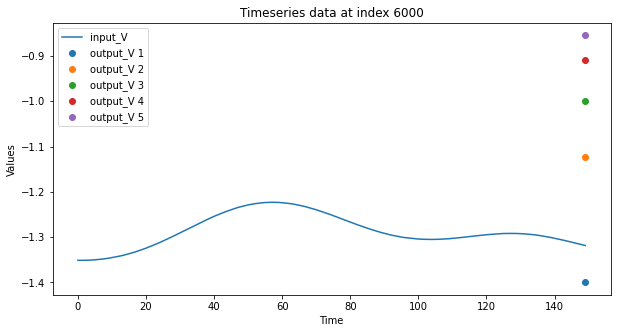

In [ ]:
data_i = 6000 # 시각화할 데이터의 index

fig = plt.figure(figsize = (10,5))
plt.title('Timeseries data at index {}'.format(data_i))
plt.xlabel('Time')
plt.ylabel('Values')

X = X_train2[data_i]
y = y_train2[data_i]
plt.plot(np.arange(len(X)), X[:, 0], label = 'input_V')
for i in range(len(y)):
    plt.scatter(len(X)-1, y[i], label = 'output_V %d'%(i+1))

plt.legend()
plt.show()

입력 전압 sequence에 따른 출력 전압값을 시각화하여 확인해보았습니다. 우리가 생성할 RNN 기반 머신러닝 모델의 목표는 `input_V`로부터 `output_V1`~`output_V5`를 예측하는 것입니다.

## 4. 머신러닝 모델 수행
---
시계열 데이터를 이용하여 RNN 기반의 딥러닝 모델을 학습하고, 예측 및 평가해보겠습니다. pytorch 라이브러리를 활용하여 대표적인 RNN 기반 모델인 LSTM과 GRU를 학습시켜 보겠습니다.


### 4.1 라이브러리 불러오기
---


In [ ]:
import numpy as np
import torch
from tqdm import tqdm

seed = 0
np.random.seed(seed)
torch.manual_seed(seed)

numpy와 pytorch를 import 해줍니다. pytorch는 `import torch`를 통해 불러올 수 있습니다. pytorch는 facebook이 개발한 파이썬 오픈소스 머신러닝 라이브러리로, tensorflow와 더불어 가장 많이 사용되는 신경망 라이브러리입니다. 결과 재현이 쉽도록 random seed를 0으로 고정해줍니다.

### 4.2 LSTM 모델
---
가장 먼저, 대표적인 RNN 모델인 long short term memory (LSTM) 모델을 학습시켜보겠습니다.

#### 4.2.1 모델 정의

In [ ]:
class LSTM(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(LSTM, self).__init__()
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, X):
        y, (hidden_states, cell_states) = self.lstm(X)
        y = self.fc(y[:, -1])
        return y


LSTM 모델의 class를 정의합니다. `torch.nn.module`은 pytorch 내 모든 신경망의 기본 class입니다. LSTM class의 생성자에서 `self.lstm`에 LSTM 네트워크를 정의합니다. `input_size`는 입력데이터의 차원을, `hidden_size`는 은닉층의 유닛 수를, `num_layers`는 은닉층의 깊이를 의미합니다. `batch_first` 가 `True`로 설정되면 입력 데이터가 `(batch, sequence, feature)` 순으로, `False`이면 `(sequence, batch, first)` 순으로 구성되어야 합니다. 우리가 사용하는 데이터는 `(batch, sequence, feature)` 순으로 되어있으므로, `batch_first = True`로 설정합니다. LSTM을 통과한 후, 최종 출력의 차원을 출력 데이터의 차원과 맞춰주기 위해 마지막 fully connected layer을 추가해줍니다. 여기서, `output_size`는 최종 출력의 차원입니다.

`forward` 메소드 내부에 모델의 forward pass를 구현합니다. forward pass의 입력 매개변수로 입력 데이터 `X`를 넣어줍니다. 생성자에서 정의한 `self.lstm`에 입력 데이터를 넣어줄 때, hidden state와 cell state를 따로 명시하지 않으면 자동으로 0-vector (원소가 모두 0인 벡터)로 초기화 됩니다. `self.lstm(X)`는 LSTM을 통과한 후의 출력값과 states를 반환합니다. 마지막으로, LSTM을 통과한 출력값을 fully conneceted layer에 통과시킨 출력값 `y`를 반환합니다. 이 때, forward pass를 위한 메소드의 이름은 반드시 `forward`여야 함에 유의하세요.

#### 4.2.2 데이터 로더 생성

모델을 학습할 때 전체 데이터에 대해 한꺼번에 학습계수를 갱신하면 메모리를 과도하게 사용하게 되고 과적합이 발생할 수 있습니다. 따라서 일반적으로 딥러닝 모델을 학습할 때에 데이터를 mini-batch 로 나누어 학습하는 stochastic gradient descent 방법을 활용합니다. 이를 위해 학습 시 데이터를 batch size 만큼 불러온 후 모델에 입력하여 학습하여야 하는데, 이로 인해 코드가 복잡해지고 가독성이 떨어질 수 있습니다.

Pytorch는 데이터를 불러오는 부분에서의 코드를 간결화하기 위해 Dataset과 DataLoader 클래스를 제공합니다. Dataset에서 입력데이터와 출력데이터를 매칭하여 저장하며, DataLoader에서 매 학습 iteration마다 데이터를 batch size만큼 불러올 수 있습니다.

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

먼저 Dataset을 상속받는 CustomDataset class를 정의합니다. 생성자에서 입력데이터와 출력데이터를 저장합니다. numpy array 형식인 데이터를 `torch.FloatTensor(...)`를 이용하여 pytorch tensor 형식으로 변환해줍니다. `__len__(...)` 메소드는 전체 데이터의 개수를 반환합니다. `__getitem__(self, index)`는 `index` 번째 데이터를 반환합니다.

In [ ]:
training_set = CustomDataset(X=X_train2, y=y_train2)
valid_set = CustomDataset(X=X_valid2, y=y_valid2)

`X`에 입력데이터를, `y`에 출력 데이터를 넣어 Dataset 객체를 생성합니다.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 256
train_dataloader = DataLoader(training_set, batch_size=batch_size, num_workers=3, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

학습 시 데이터를 사용자가 설정한 batch size 만큼만 불러올 수 있도록 하기 위해 pytorch 에서 DataLoader 클래스를 이용할 수 있습니다. 이 때, `shuffle = True`로 설정하여 매 에폭마다 데이터가 잘 섞일 수 있도록 해줍니다.

#### 4.2.3 모델 생성

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

input_size = X_train2.shape[-1]
output_size = y_train2.shape[-1]
hidden_size = 32
num_layers = 2
lstm_model = LSTM(input_size = input_size, hidden_size = hidden_size, output_size = output_size, num_layers = num_layers)
lstm_model.to(device)

LSTM(
  (lstm): LSTM(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

두 개 층의 LSTM 레이어로 구성된 모델을 생성해보았습니다. 입력 데이터 (`X_train2`)의 차원은 1이므로, `input_size = 1`로 설정합니다. 각 레이어의 유닛 수는 32로 설정하였고, 마지막 dense layer의 출력 차원은 `proj_size = 5`로 출력 데이터 `y`의 차원과 같은 5로 설정합니다.

#### 4.2.4 모델 학습

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.01)

학습 loss는 mean squared error를 이용하며, optimizer는 Adam optimzier를 이용합니다. 학습률은 0.01로 설정합니다.

In [ ]:
EPOCHS = 10
max_iter = 50

학습 batch size는 256으로 설정하고, 총 10 에폭 동안 학습합니다. 각 에폭마다 최대 iteration 수는 50으로 설정합니다.

In [ ]:
history = {
    'training_loss': [],
    'validation_loss': []
}

for epoch in range(1, EPOCHS + 1):
    # 모델 학습을 위해 gradient를 계산하도록 설정합니다.
    lstm_model.train()

    epoch_loss = 0
    pbar = tqdm(train_dataloader)
    i = 0
    for data in pbar:
        if i >= max_iter:
            break

        X_batch, y_batch = data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = lstm_model(X_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        epoch_loss += loss.item()
        pbar.set_description(f'[Epoch {epoch}/{EPOCHS}] loss = {loss:.5e}')

    # 검증: 학습을 위한 단계가 아니므로, gradient를 계산하지 않도록 합니다.
    lstm_model.eval()
    valid_loss = 0
    i = 0
    for data in valid_dataloader:
        if i >= max_iter:
            break

        X_batch, y_batch = data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = lstm_model(X_batch)
        loss = criterion(pred, y_batch)

        valid_loss += loss.item()

    print(
        f'Train loss: {epoch_loss / min(len(train_dataloader), max_iter):.5e}, '
        f'Valid loss: {valid_loss / min(len(valid_dataloader), max_iter):.5e}'
    )

    history['training_loss'].append(epoch_loss / min(len(train_dataloader), max_iter))
    history['validation_loss'].append(valid_loss / min(len(valid_dataloader), max_iter))

  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.35939e-01, Valid loss: 3.56382e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 7.42178e-03, Valid loss: 2.05592e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 5.66167e-03, Valid loss: 1.84317e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 4.93046e-03, Valid loss: 1.63044e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 3.38778e-03, Valid loss: 9.73951e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.94871e-03, Valid loss: 6.04133e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.47716e-03, Valid loss: 4.45086e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.26651e-03, Valid loss: 3.92709e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.13641e-03, Valid loss: 3.63229e-03


[Epoch 10/10] loss = 8.26727e-04:   3%|▎         | 50/1589 [00:26<13:36,  1.89it/s] 


Train loss: 1.06056e-03, Valid loss: 2.84850e-03


모델을 학습합니다. 매 에폭이 끝날때마다 검증용 데이터를 이용하여 loss를 확인해봅니다. 또한, 매 에폭마다 학습 로스와 검증 로스를 history 딕셔너리에 추가해줍니다.

#### 4.2.5 학습 중 Loss 변화 그래프로 확인하기

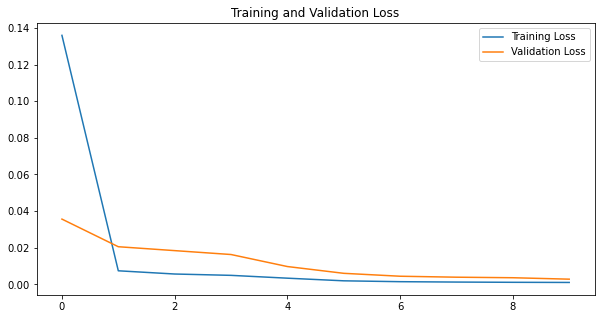

In [ ]:
train_loss = history['training_loss']
val_loss = history['validation_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4.2.6 모델 예측

`X_test2`에 대한 예측 결과를 계산합니다.

In [ ]:
test_set = CustomDataset(X=X_test2, y=y_test2)
test_dataloader = DataLoader(test_set, batch_size=1024, shuffle=False)

In [ ]:
lstm_model.eval()
test_loss = 0
preds = []
for data in tqdm(test_dataloader):
    X_batch, y_batch = data
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    pred = lstm_model(X_batch)
    loss = criterion(pred, y_batch)

    test_loss += loss.item()
    preds.append(pred.detach().cpu().numpy())

preds = np.concatenate(preds, axis=0)
print(f'Test loss: {test_loss / len(test_dataloader):.5e}')

100%|██████████| 189/189 [02:17<00:00,  1.37it/s]

Test loss: 8.08772e-04


In [ ]:
preds.shape

(193387, 5)

#### 4.2.7 모델 성능 평가

In [ ]:
def mse(gt, pred):
    data_len = len(gt)

    return ((gt - pred) ** 2).sum() / data_len

평균 mean squared error을 계산해주는 함수를 정의합니다.

In [ ]:
error = mse(preds, y_test2)
print(f'LSTM 모델의 오차: {error:.5e}')

LSTM 모델의 오차: 4.04646e-03


`pred`를 `numpy` array로 형변환해주고, MSE를 계산합니다. LSTM 모델이 프로젝트 2에서 학습시킨 단순 회귀 모델보다 더 작은 오차를 보임을 확인할 수 있습니다.

#### 4.2.8 예측결과 시각화

In [ ]:
X_test2[:,-1:, 0].shape

(193387, 1)

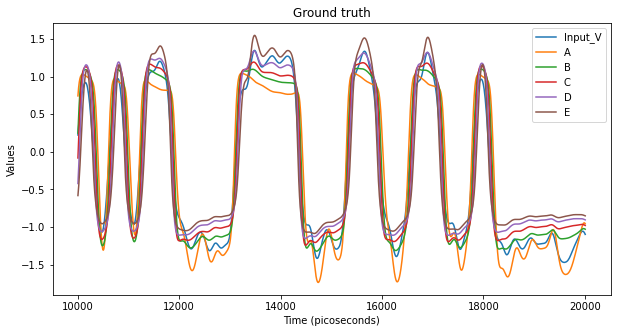

In [ ]:
start_i, end_i = 10000, 20000

fig = plt.figure(figsize = (10,5))
plt.title('Ground truth')
plt.xlabel('Time (picoseconds)')
plt.ylabel('Values')
for i, data in enumerate(np.concatenate([X_test2[:,-1:, 0], y_test2], axis=1).transpose()):
    plt.plot(df_train.iloc[start_i:end_i, 0] * 1e+12, data[start_i:end_i], label = df_train.columns[i+1])
plt.legend(loc = 'upper right')
plt.show()

먼저 정답 데이터를 그래프로 그려봅니다.

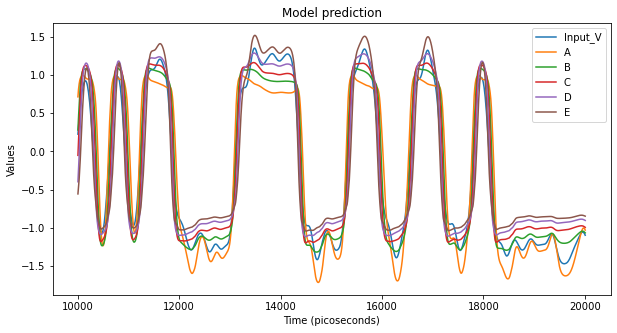

In [ ]:
fig = plt.figure(figsize = (10,5))
plt.title('Model prediction')
plt.xlabel('Time (picoseconds)')
plt.ylabel('Values')
for i, data in enumerate(np.concatenate([X_test2[:,-1:, 0], preds], axis=1).transpose()):
    plt.plot(df_train.iloc[start_i:end_i, 0] * 1e+12, data[start_i:end_i], label = df_train.columns[i+1])
plt.legend(loc = 'upper right')
plt.show()

다음으로 LSTM 모델이 예측한 결과를 그래프로 그려봅니다. 실제 출력전압과 유사하게 예측해내었음을 확인할 수 있습니다.

### 4.3 GRU 모델
---
이번에는, 또 다른 대표적인 RNN 모델인 gated recurrent unit (GRU) 모델을 학습시켜보겠습니다.

#### 4.3.1 모델 정의

## [TODO] GRU 모델 class 정의하기

4.2.1 에서의 LSTM 대신 GRU 레이어를 이용하여 모델을 정의해보세요.

In [ ]:
class GRU(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(GRU, self).__init__()
        self.gru = torch.nn.GRU(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, X):
        y, hidden_states = self.gru(X)
        y = self.fc(y[:, -1])
        return y

GRU 모델은 cell state가 없고 hidden state만 있음에 유의하세요!

#### 4.3.2 데이터 로더 생성

## [TODO] 데이터로더 생성하기

4.2.2 에서 처럼 데이터 로더를 생성해줍니다.

In [ ]:
from torch.utils.data import Dataset

class CustomDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.FloatTensor(X)
        self.y = torch.FloatTensor(y)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, index):
        X = self.X[index]
        y = self.y[index]
        return X, y

먼저 Dataset을 상속받는 CustomDataset class를 정의합니다. 생성자에서 입력데이터와 출력데이터를 저장합니다. numpy array 형식인 데이터를 `torch.FloatTensor(...)`를 이용하여 pytorch tensor 형식으로 변환해줍니다. `__len__(...)` 메소드는 전체 데이터의 개수를 반환합니다. `__getitem__(self, index)`는 `index` 번째 데이터를 반환합니다.

In [ ]:
training_set = CustomDataset(X=X_train2, y=y_train2)
valid_set = CustomDataset(X=X_valid2, y=y_valid2)

`X`에 입력데이터를, `y`에 출력 데이터를 넣어 Dataset 객체를 생성합니다.

In [ ]:
from torch.utils.data import DataLoader

batch_size = 256
train_dataloader = DataLoader(training_set, batch_size=batch_size, num_workers=3, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

학습 시 데이터를 사용자가 설정한 batch size 만큼만 불러올 수 있도록 하기 위해 pytorch 에서 DataLoader 클래스를 이용할 수 있습니다. 이 때, train의 경우 `shuffle = True`로 설정하여 매 에폭마다 데이터가 잘 섞일 수 있도록 해줍니다. batch size는 256으로 설정해줍니다.

#### 4.3.3 모델 생성

## [TODO] GRU 모델 생성하기

In [ ]:
input_size = X_train2.shape[-1]
output_size = y_train2.shape[-1]
hidden_size = 32
num_layers = 2
gru_model = GRU(input_size = input_size, hidden_size = hidden_size, output_size = output_size, num_layers = num_layers)
gru_model.to(device)

GRU(
  (gru): GRU(1, 32, num_layers=2, batch_first=True)
  (fc): Linear(in_features=32, out_features=5, bias=True)
)

4.2 에서의 LSTM 세팅과 같도록 GRU 모델을 생성해보세요.

#### 4.3.4 모델 학습하기

이렇게 만들어진 모델에 학습 데이터와 검증 데이터를 사용하여 학습시켜보겠습니다.

## [TODO] 모델 학습 코드를 작성해보세요.

In [ ]:
criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(gru_model.parameters(), lr=0.01)

optimizer는 `adam`을 사용하고, loss는 mean squared error (`mse`)로 설정합니다.

In [ ]:
EPOCHS = 10
max_iter = 50

4.2.3 에서처럼 생성한 GRU 모델을 학습하는 코드를 작성하세요. 10 에폭 동안 학습하며 `max_iter`은 50으로 설정합니다.

In [ ]:
history = {
    'training_loss': [],
    'validation_loss': []
}

for epoch in range(1, EPOCHS + 1):
    # 모델 학습을 위해 gradient를 계산하도록 설정합니다.
    gru_model.train()

    epoch_loss = 0
    pbar = tqdm(train_dataloader)
    i = 0
    for data in pbar:
        if i >= max_iter:
            break

        X_batch, y_batch = data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = gru_model(X_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        epoch_loss += loss.item()
        pbar.set_description(f'[Epoch {epoch}/{EPOCHS}] loss = {loss:.5e}')

    # 검증: 학습을 위한 단계가 아니므로, gradient를 계산하지 않도록 합니다.
    gru_model.eval()
    valid_loss = 0
    i = 0
    for data in valid_dataloader:
        if i >= max_iter:
            break

        X_batch, y_batch = data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = gru_model(X_batch)
        loss = criterion(pred, y_batch)

        valid_loss += loss.item()

    print(
        f'Train loss: {epoch_loss / min(len(train_dataloader), max_iter):.5e},'
        f'Valid loss: {valid_loss / min(len(valid_dataloader), max_iter):.5e}'
    )

    history['training_loss'].append(epoch_loss / min(len(train_dataloader), max_iter))
    history['validation_loss'].append(valid_loss / min(len(valid_dataloader), max_iter))

  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.02979e-01,Valid loss: 3.03177e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 5.57065e-03,Valid loss: 1.26405e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 2.90028e-03,Valid loss: 5.86136e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.20039e-03,Valid loss: 3.45621e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 8.72131e-04,Valid loss: 2.69780e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 7.23996e-04,Valid loss: 2.37809e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 6.45035e-04,Valid loss: 1.92879e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 6.07418e-04,Valid loss: 1.96027e-03


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 5.75145e-04,Valid loss: 1.78203e-03


[Epoch 10/10] loss = 5.24435e-04:   3%|▎         | 50/1589 [00:22<11:22,  2.25it/s] 


Train loss: 5.77996e-04,Valid loss: 2.24102e-03


4.2.4 를 참고하여 학습코드를 직접 작성해보세요.

#### 4.3.5 학습 중 Loss 변화 그래프로 확인하기

모델을 학습하면서 출력되는 손실값을 확인할 수 있습니다.

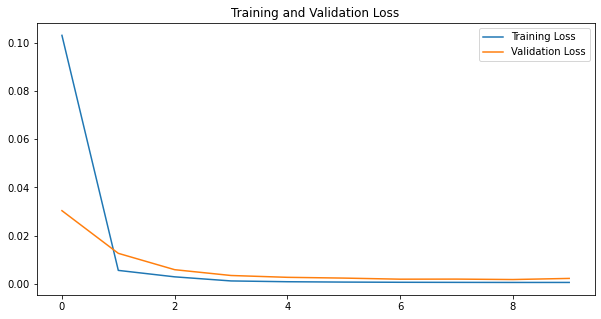

In [ ]:
train_loss = history['training_loss']
val_loss = history['validation_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(10, 5))
plt.plot(epochs_range, train_loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 4.3.5 모델 예측

## [TODO] GRU 모델을 활용하여 테스트 데이터에 대한 예측을 수행하는 코드를 작성해보세요.

4.2. 에서처럼 테스트 데이터 (`X_test2`)에 대한 GRU 모델의 예측 결과를 `pred` 변수에 저장하는 코드를 작성하세요.

In [ ]:
test_set = CustomDataset(X=X_test2, y=y_test2)
test_dataloader = DataLoader(test_set, batch_size=1024, shuffle=False)

In [ ]:
gru_model.eval()
test_loss = 0
preds = []
for data in tqdm(test_dataloader):
    X_batch, y_batch = data
    X_batch = X_batch.to(device)
    y_batch = y_batch.to(device)

    pred = gru_model(X_batch)
    loss = criterion(pred, y_batch)

    test_loss += loss.item()
    preds.append(pred.detach().cpu().numpy())

preds = np.concatenate(preds, axis=0)
print(f'Test loss: {test_loss / len(test_dataloader):.5e}')

100%|██████████| 189/189 [01:40<00:00,  1.88it/s]

Test loss: 6.31115e-04


`predict` 함수를 이용하여 테스트 입력 데이터 (`X_test2`)의 출력값을 예측합니다.

#### 4.3.6 모델 성능 평가

In [ ]:
def mse(gt, pred):
    data_len = len(gt)
    return ((gt - pred) ** 2).sum() / data_len

평균 mean squared error을 계산해주는 함수를 정의합니다.

In [ ]:
error = mse(preds, y_test2)
print(f'GRU 모델의 오차: {error:.5e}')

GRU 모델의 오차: 3.15657e-03


GRU 모델이 프로젝트 2에서 학습시킨 단순 회귀 모델보다 더 작은 오차를 보임을 확인할 수 있습니다.

#### 4.3.7 예측 결과 시각화

먼저 정답 데이터를 그래프로 그려봅니다.

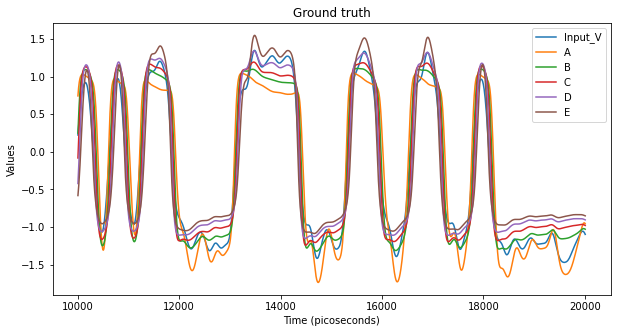

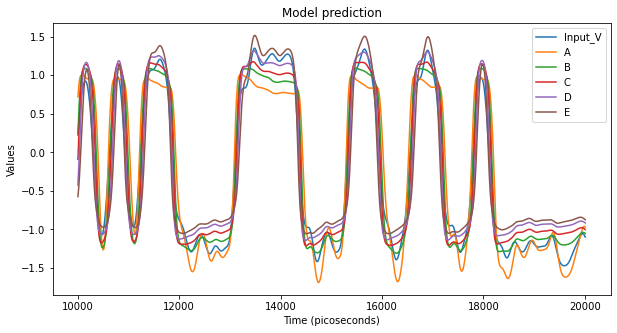

In [ ]:
start_i, end_i = 10000, 20000

# 정답 데이터 그래프 그리기
fig = plt.figure(figsize = (10,5))
plt.title('Ground truth')
plt.xlabel('Time (picoseconds)')
plt.ylabel('Values')
for i, data in enumerate(np.concatenate([X_test2[:,-1:, 0], y_test2], axis=1).transpose()):
    plt.plot(df_train.iloc[start_i:end_i, 0] * 1e+12, data[start_i:end_i], label = df_train.columns[i+1])
plt.legend(loc = 'upper right')
plt.show()

# 예측 결과 그래프 그리기
fig = plt.figure(figsize = (10,5))
plt.title('Model prediction')
plt.xlabel('Time (picoseconds)')
plt.ylabel('Values')
for i, data in enumerate(np.concatenate([X_test2[:,-1:, 0], preds], axis=1).transpose()):
    plt.plot(df_train.iloc[start_i:end_i, 0] * 1e+12, data[start_i:end_i], label = df_train.columns[i+1])
plt.legend(loc = 'upper right')
plt.show()

다음으로 GRU 모델이 예측한 결과를 그래프로 그려봅니다. 실제 출력전압과 유사하게 예측해내었음을 확인할 수 있습니다.

## 5. 더 해보기
---
여기까지 전압 파형 데이터를 활용하여 입력 전압 sequence로부터 출력 전압을 예측하는 머신러닝 모델 솔루션을 구축해보았습니다. `pandas` 라이브러리로 raw 데이터를 읽어오고 가공하여 다양한 머신러닝 모델에 활용할 수 있는 형태로 변환해보았고, `scikit-learn`과 `pytorch` 패키지를 활용하여 다양한 머신러닝 모델을 생성해보았습니다. 전압파형과 같은 시계열 데이터는 단순 회귀 모델보다 RNN 기반 모델이 더 좋은 성능을 보임을 확인하였습니다. 이번 프로젝트를 진행하면서 사람이 직접 설정해줘야 하는 몇가지 hyper parameter들이 있었습니다. 데이터를 생성할 때 window size와 데이터 사이의 간격 등을 설정할 수 있었고, 모델을 학습할 때 batch size나 unit의 수, 그리고 모델의 종류와 레이어의 개수 등을 설정할 수 있었습니다. 최적화된 모델을 고안하기 위하여 계산량과 메모리, 그리고 성능을 모두 고려하여야 하고, 그러기 위해 `matplotlib` 라이브러리를 활용한 시각화를 유용하게 사용할 수 있습니다.


## [TODO] 아래 지시사항에 따라 새로운 시계열 모델을 직접 만들어보세요.

#### 5.1 데이터 전처리

In [ ]:
num_sequences = 500
stride = 10
interval = 5
X_train2, y_train2 = process_data(X_train, y_train, num_sequences, stride, interval)
X_valid2, y_valid2 = process_data(X_valid, y_valid, num_sequences, stride, interval)
X_test2, y_test2 = process_data(X_test, y_test, num_sequences, stride, interval)

#### 5.2 모델 정의

In [ ]:
class CustomRNN(torch.nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers):
        super(CustomRNN, self).__init__()
        self.lstm = torch.nn.LSTM(input_size = input_size, hidden_size = hidden_size, num_layers = num_layers, batch_first = True)
        self.fc = torch.nn.Linear(hidden_size, output_size)

    def forward(self, X):
        y, (hidden_states, cell_states) = self.lstm(X)
        y = self.fc(y[:, -1])
        return y

#### 5.3 모델 생성

In [ ]:
input_size = X_train2.shape[-1]
output_size = y_train2.shape[-1]
hidden_size = 64
num_layers = 1
custom_model = CustomRNN(input_size = input_size, hidden_size = hidden_size, output_size = output_size, num_layers = num_layers)
custom_model.to(device)

CustomRNN(
  (lstm): LSTM(1, 64, batch_first=True)
  (fc): Linear(in_features=64, out_features=5, bias=True)
)

#### 5.4 모델 학습

In [ ]:
batch_size = 256
train_dataloader = DataLoader(training_set, batch_size=batch_size, num_workers=3, shuffle=True)
valid_dataloader = DataLoader(valid_set, batch_size=batch_size, shuffle=False)

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(custom_model.parameters(), lr=0.01)

EPOCHS = 5
max_iter = 50


history = {
    'training_loss': [],
    'validation_loss': []
}

for epoch in range(1, EPOCHS + 1):
    # 모델 학습을 위해 gradient를 계산하도록 설정합니다.
    custom_model.train()

    epoch_loss = 0
    pbar = tqdm(train_dataloader)
    i = 0
    for data in pbar:
        if i >= max_iter:
            break

        X_batch, y_batch = data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = custom_model(X_batch)
        loss = criterion(pred, y_batch)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        i += 1
        epoch_loss += loss.item()
        pbar.set_description(f'[Epoch {epoch}/{EPOCHS}] loss = {loss:.5e}')

    # 검증: 학습을 위한 단계가 아니므로, gradient를 계산하지 않도록 합니다.
    custom_model.eval()
    valid_loss = 0
    i = 0
    for data in valid_dataloader:
        if i >= max_iter:
            break

        X_batch, y_batch = data
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        pred = custom_model(X_batch)
        loss = criterion(pred, y_batch)

        valid_loss += loss.item()

    print(
        f'Train loss: {epoch_loss / min(len(train_dataloader), max_iter):.5e}, '
        f'Valid loss: {valid_loss / min(len(valid_dataloader), max_iter):.5e}'
    )

    history['training_loss'].append(epoch_loss / min(len(train_dataloader), max_iter))
    history['validation_loss'].append(valid_loss / min(len(valid_dataloader), max_iter))

  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 1.91703e-01, Valid loss: 1.95126e-01


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 2.73268e-02, Valid loss: 3.25898e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 7.09837e-03, Valid loss: 2.05421e-02


  0%|          | 0/1589 [00:00<?, ?it/s]

Train loss: 5.73395e-03, Valid loss: 1.89088e-02


[Epoch 5/5] loss = 5.46504e-03:   3%|▎         | 50/1589 [00:22<11:24,  2.25it/s] 


Train loss: 5.35368e-03, Valid loss: 1.77398e-02


<span style="color:rgb(120, 120, 120)">본 학습 자료를 포함한 사이트 내 모든 자료의 저작권은 엘리스에 있으며 외부로의 무단 복제, 배포 및 전송을 불허합니다.

Copyright @ elice all rights reserved</span>

---